In [1]:
!pip install matplotlib scipy numpy pillow

In [2]:
from mtree import MTree
from fingerprint_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import namedtuple

plt.style.use('dark_background')

In [3]:
gallery_dataset = {"path": "/data/gallery/", "img_path": "images/", "patch_path": "patches/", "mnt_path": "mnts/", "features_path": "features/ResNet18_1013_213017/"}
queries_dataset = {"path": "/data/query_basep/", "img_path": "images/", "patch_path": "patches/", "mnt_path": "mnts/", "features_path": "features/ResNet18_1013_213017/"}

In [4]:
def get_features(data:dict) -> np.ndarray:
    features = np.load(data["path"] + data["features_path"] + data["individual"] + ".npy")
    return features

## Carregando dados da galeria

In [5]:
# Create a list with all individual names (present in /data/gallery/list.txt)
with open(gallery_dataset["path"] + "list.txt") as f:
    gallery_individuals = f.read().splitlines()
print(len(gallery_individuals))

2786


## Construindo a MTree

- Definindo a métrica
- Definindo o tipo de dado que vai ser armazenado

$$\text{(Tamanho da arvore)} = \text{(\# de individuos)}\times\text{(\# de features)}$$

In [6]:
# MTree metric
def L2(a, b):
    return distance.euclidean(a.vec, b.vec)

# MTree elements
Feature = namedtuple('Feature', ['vec', 'id_finger', 'id_minutia'])

In [7]:
# Build MTree with features
mtree = MTree(d=L2,max_node_size=8)

# For all individuals in gallery
for i in range(len(gallery_individuals[:300])):
    features = get_features({**gallery_dataset, "individual": gallery_individuals[i]})
    
    # For all features in individual
    for j in range(len(features)):
        mtree.add(Feature(vec=features[j, :], id_finger=i, id_minutia=j))

## Busca individual

Buscar uma minúcia na árvore

In [8]:
# k-NN search
i = 5
j = 0

features = get_features({**gallery_dataset, "individual": gallery_individuals[i]})
query = Feature(vec=features[j, :], id_finger=i, id_minutia=j)

k = 8
result = list(mtree.search(query, k))

In [18]:
D = {}
for r in result:
        key = (r.id_finger, r.id_minutia)
        lst = D.get(key, [])
        lst.append(L2(r, query))
        D[key] = lst
D

{(5, 0): [0.0],
 (5, 20): [0.5241934657096863],
 (5, 4): [0.5410779714584351],
 (5, 18): [0.5501453280448914],
 (5, 12): [0.7052182555198669],
 (253, 74): [0.7351144552230835],
 (5, 38): [0.7354328036308289],
 (16, 0): [0.7489640116691589]}

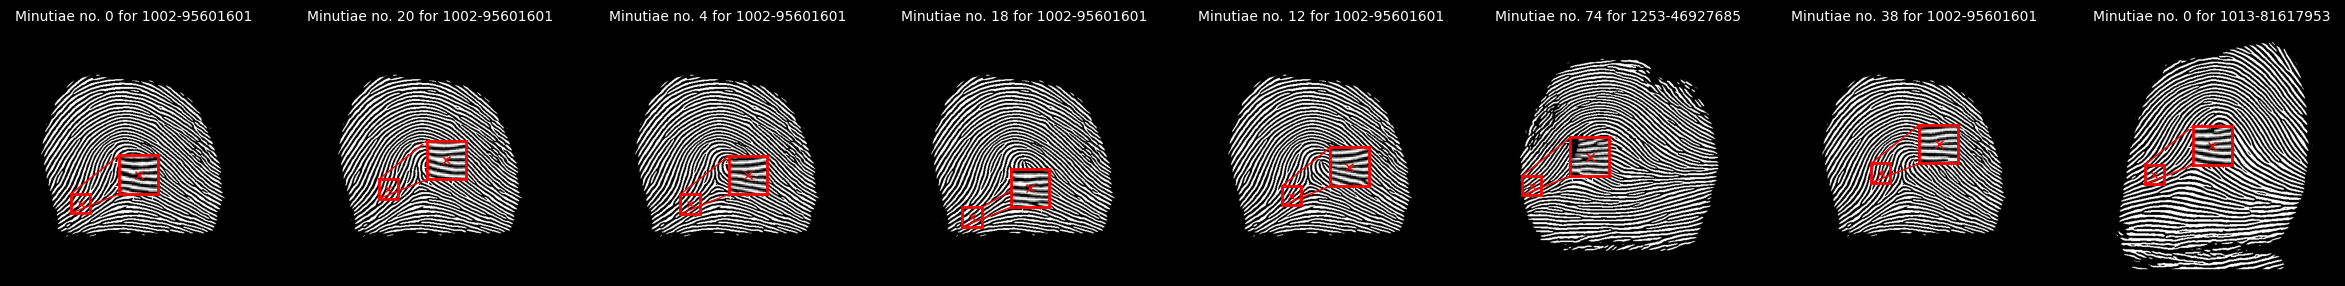

In [19]:
individuals = [gallery_individuals[r.id_finger] for r in result]
minutiae = [r.id_minutia for r in result]

plot_minutia_compare(individuals, minutiae, gallery_dataset, fontsize=10, figsize=(30, 30))

## Buscando Indivíduo

- Fazer uma busca
- Com os resultados:
    - Criar um dicionário com chaves (id_finger, id_minutia)
    - Adicionar no valor do dicionário uma lista com as distância

In [39]:
%%time

# Buscando um indivíduo específico
i = 5

features = get_features({**gallery_dataset, "individual": gallery_individuals[i]})

# Fazer queries para todas as features do indivíduo
D = {}
k = 8
for j in range(len(features)):
    query = Feature(vec=features[j, :], id_finger=i, id_minutia=j)
    result = list(mtree.search(query, k))
    
    # Atribuir a lista com score
    for r in result:
        key = (r.id_finger, r.id_minutia)
        lst = D.get(key, [])
        lst.append(L2(r, query))
        D[key] = lst

CPU times: user 33.9 s, sys: 48.1 ms, total: 34 s
Wall time: 34 s


In [67]:
score = lambda item: len(item[1])**(3/4)/(np.mean(item[1]) + .15) 

# Sort D by mean score
D1 = {k: v for k, v in sorted(D.items(), key=score, reverse=True)}

for key in D1:
    print(key, "mean = ", f"{np.mean(D1[key]):.3f}", "| noMatches = ", len(D1[key]), "| score =", f"{score((key, D1[key])):.3f}")

(5, 4) mean =  0.521 | noMatches =  11 | score = 9.004
(5, 12) mean =  0.517 | noMatches =  10 | score = 8.430
(5, 26) mean =  0.553 | noMatches =  10 | score = 8.001
(5, 21) mean =  0.494 | noMatches =  8 | score = 7.384
(5, 2) mean =  0.512 | noMatches =  8 | score = 7.184
(5, 39) mean =  0.520 | noMatches =  8 | score = 7.099
(5, 7) mean =  0.521 | noMatches =  8 | score = 7.094
(5, 20) mean =  0.462 | noMatches =  7 | score = 7.029
(5, 3) mean =  0.546 | noMatches =  8 | score = 6.836
(5, 30) mean =  0.555 | noMatches =  8 | score = 6.748
(5, 11) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 25) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 27) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 34) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 42) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 50) mean =  0.000 | noMatches =  1 | score = 6.667
(5, 55) mean =  0.574 | noMatches =  8 | score = 6.567
(5, 22) mean =  0.517 | noMatches =  7 | score = 6.455
(5, 28) mea

In [66]:
Scores = {}
for d in D1.items():
    Scores[d[0][0]] = Scores.get(d[0][0], 0) + score(d)
# Sort Scores
Scores = {k: v for k, v in sorted(Scores.items(), key=lambda item: item[1], reverse=True)}

for s in Scores:
    print("Sample:", s, "| Score:", f"{Scores[s]:.3f}")

Sample: 5 | Score: 326.873
Sample: 8 | Score: 45.653
Sample: 222 | Score: 8.196
Sample: 213 | Score: 8.062
Sample: 268 | Score: 7.465
Sample: 253 | Score: 7.444
Sample: 51 | Score: 7.263
Sample: 16 | Score: 7.238
Sample: 267 | Score: 5.395
Sample: 64 | Score: 5.266
Sample: 33 | Score: 5.264
Sample: 139 | Score: 4.848
Sample: 41 | Score: 3.624
Sample: 162 | Score: 3.451
Sample: 142 | Score: 3.382
Sample: 194 | Score: 3.378
Sample: 269 | Score: 3.182
Sample: 124 | Score: 3.050
Sample: 279 | Score: 3.011
Sample: 85 | Score: 2.983
Sample: 78 | Score: 2.528
Sample: 154 | Score: 2.336
Sample: 199 | Score: 2.336
Sample: 109 | Score: 2.226
Sample: 71 | Score: 2.165
Sample: 30 | Score: 2.114
Sample: 32 | Score: 2.114
Sample: 90 | Score: 2.097
Sample: 297 | Score: 2.051
Sample: 107 | Score: 2.043
Sample: 153 | Score: 2.029
Sample: 218 | Score: 2.020
Sample: 129 | Score: 1.995
Sample: 12 | Score: 1.862
Sample: 10 | Score: 1.754
Sample: 286 | Score: 1.269
Sample: 295 | Score: 1.267
Sample: 61 | Sc